In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Loading and Cleaning

In [2]:
# Step 1: Load the Data
file_path = '/Users/rohanpadaya/Desktop/pankit_assign/Stock_data_part1.csv'  
stock_data_1 = pd.read_csv(file_path, low_memory=False)


In [3]:
# Step 2: Convert RET to numeric, coercing errors
stock_data_1['RET'] = pd.to_numeric(stock_data_1['RET'], errors='coerce')

# Check for any other object types that should be numeric
stock_data_1['SHRCD'] = pd.to_numeric(stock_data_1['SHRCD'], errors='coerce')

# Step 3: Convert 'date' column to datetime
stock_data_1['date'] = pd.to_datetime(stock_data_1['date'])

# Drop rows with NaN in critical columns (RET, PRC, BID, ASK)
stock_data_1_cleaned = stock_data_1.dropna(subset=['RET', 'PRC', 'BID', 'ASK', 'TICKER'])

# Drop the NUMTRD column due to excessive missing values
stock_data_1_cleaned = stock_data_1_cleaned.drop(columns=['NUMTRD'])

# Consider dropping or filling OPENPRC based on its necessity
# Example: Drop OPENPRC if not essential
stock_data_1_cleaned = stock_data_1_cleaned.drop(columns=['OPENPRC'])

# Handle remaining columns with moderate NaN values
# Example: Drop rows with missing BIDLO, ASKHI, VOL
stock_data_1_cleaned = stock_data_1_cleaned.dropna(subset=['BIDLO', 'ASKHI', 'VOL'])

# Optionally fill missing values in columns with very few NaNs, like SHRCD, COMNAM, and SHROUT
# For example, filling with the mode or a placeholder value
stock_data_1_cleaned['SHRCD'].fillna(stock_data_1_cleaned['SHRCD'].mode()[0], inplace=True)
stock_data_1_cleaned['COMNAM'].fillna("Unknown", inplace=True)
stock_data_1_cleaned['SHROUT'].fillna(stock_data_1_cleaned['SHROUT'].median(), inplace=True)


In [4]:
stock_data_1_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1926738 entries, 0 to 1938800
Data columns (total 15 columns):
 #   Column  Dtype         
---  ------  -----         
 0   PERMNO  int64         
 1   date    datetime64[ns]
 2   SHRCD   float64       
 3   TICKER  object        
 4   COMNAM  object        
 5   PERMCO  int64         
 6   BIDLO   float64       
 7   ASKHI   float64       
 8   PRC     float64       
 9   VOL     float64       
 10  RET     float64       
 11  BID     float64       
 12  ASK     float64       
 13  SHROUT  float64       
 14  sprtrn  float64       
dtypes: datetime64[ns](1), float64(10), int64(2), object(2)
memory usage: 235.2+ MB


# Incorporating Fama French data

In [5]:
import pandas as pd

# Load the Fama-French factors data
fama_french_data = pd.read_csv('/Users/rohanpadaya/Downloads/F-F_Research_Data_Factors.CSV', skiprows=3)

# Rename the columns for clarity
fama_french_data.columns = ['Date', 'Mkt_RF', 'SMB', 'HML', 'RF']

# Remove rows where 'Date' is NaN
fama_french_data = fama_french_data.dropna(subset=['Date'])

# Filter out any non-date rows in the 'Date' column
fama_french_data = fama_french_data[fama_french_data['Date'].str.isnumeric()]

# Convert the 'Date' column to a datetime format
fama_french_data['Date'] = pd.to_datetime(fama_french_data['Date'], format='%Y%m').dt.to_period('M')

# Filter the Fama-French data for the relevant periods (December 2019 - March 2020)
fama_french_data = fama_french_data[(fama_french_data['Date'] >= '2019-12') & (fama_french_data['Date'] <= '2020-03')]

# Check the data
print(fama_french_data.head())


         Date    Mkt_RF       SMB       HML        RF
1121  2019-12      2.77      0.73      1.78      0.14
1122  2020-01     -0.11     -3.13     -6.25      0.13
1123  2020-02     -8.13      1.07     -3.80      0.12
1124  2020-03    -13.39     -4.79    -13.88      0.13


In [6]:
fama_french_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 1121 to 1124
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   Date    4 non-null      period[M]
 1   Mkt_RF  4 non-null      object   
 2   SMB     4 non-null      object   
 3   HML     4 non-null      object   
 4   RF      4 non-null      object   
dtypes: object(4), period[M](1)
memory usage: 192.0+ bytes


In [7]:
# Convert the Fama-French factors (Mkt_RF, SMB, HML, RF) to numeric
fama_french_data[['Mkt_RF', 'SMB', 'HML', 'RF']] = fama_french_data[['Mkt_RF', 'SMB', 'HML', 'RF']].apply(pd.to_numeric, errors='coerce')

# Ensure the date columns are properly aligned for merging
stock_data_1_cleaned['Month'] = stock_data_1_cleaned['date'].dt.to_period('M')

# The fama_french_data['Date'] is already in period[M], so we can use it directly
fama_french_data['Month'] = fama_french_data['Date']

# Now try merging the data again
merged_data = pd.merge(stock_data_1_cleaned, fama_french_data, on='Month', how='inner')

# Check the merged data
print(merged_data.head())

   PERMNO       date  SHRCD TICKER                  COMNAM  PERMCO   BIDLO  \
0   10026 2019-12-02   11.0   JJSF  J & J SNACK FOODS CORP    7976  182.73   
1   10026 2019-12-03   11.0   JJSF  J & J SNACK FOODS CORP    7976  183.06   
2   10026 2019-12-04   11.0   JJSF  J & J SNACK FOODS CORP    7976  186.72   
3   10026 2019-12-05   11.0   JJSF  J & J SNACK FOODS CORP    7976  186.20   
4   10026 2019-12-06   11.0   JJSF  J & J SNACK FOODS CORP    7976  187.97   

       ASKHI        PRC       VOL  ...        BID        ASK   SHROUT  \
0  186.41000  184.25000  121203.0  ...  183.97000  184.17999  18899.0   
1  187.06000  186.94000  112357.0  ...  186.97000  187.08000  18899.0   
2  189.21001  188.10001   63753.0  ...  188.00999  188.24001  18899.0   
3  188.24001  188.00999   93226.0  ...  188.00999  188.25000  18899.0   
4  189.80000  188.80000   65086.0  ...  188.80000  188.98000  18899.0   

     sprtrn    Month     Date Mkt_RF   SMB   HML    RF  
0 -0.008631  2019-12  2019-12   2.7

In [8]:
# Define the periods
covid_start = '2020-02-14'
covid_end = '2020-03-20'
non_covid_start = '2019-12-14'
non_covid_end = '2020-01-20'

# Filter the data for COVID and Non-COVID periods
covid_data = merged_data[(merged_data['date'] >= covid_start) & (merged_data['date'] <= covid_end)]
non_covid_data = merged_data[(merged_data['date'] >= non_covid_start) & (merged_data['date'] <= non_covid_end)]

In [9]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189401 entries, 318763 to 629557
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   PERMNO  189401 non-null  int64         
 1   date    189401 non-null  datetime64[ns]
 2   SHRCD   189401 non-null  float64       
 3   TICKER  189401 non-null  object        
 4   COMNAM  189401 non-null  object        
 5   PERMCO  189401 non-null  int64         
 6   BIDLO   189401 non-null  float64       
 7   ASKHI   189401 non-null  float64       
 8   PRC     189401 non-null  float64       
 9   VOL     189401 non-null  float64       
 10  RET     189401 non-null  float64       
 11  BID     189401 non-null  float64       
 12  ASK     189401 non-null  float64       
 13  SHROUT  189401 non-null  float64       
 14  sprtrn  189401 non-null  float64       
 15  Month   189401 non-null  period[M]     
 16  Date    189401 non-null  period[M]     
 17  Mkt_RF  189401 non-null  floa

In [10]:
non_covid_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174491 entries, 10 to 318744
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   PERMNO  174491 non-null  int64         
 1   date    174491 non-null  datetime64[ns]
 2   SHRCD   174491 non-null  float64       
 3   TICKER  174491 non-null  object        
 4   COMNAM  174491 non-null  object        
 5   PERMCO  174491 non-null  int64         
 6   BIDLO   174491 non-null  float64       
 7   ASKHI   174491 non-null  float64       
 8   PRC     174491 non-null  float64       
 9   VOL     174491 non-null  float64       
 10  RET     174491 non-null  float64       
 11  BID     174491 non-null  float64       
 12  ASK     174491 non-null  float64       
 13  SHROUT  174491 non-null  float64       
 14  sprtrn  174491 non-null  float64       
 15  Month   174491 non-null  period[M]     
 16  Date    174491 non-null  period[M]     
 17  Mkt_RF  174491 non-null  float64 

In [11]:
# Define the stock and ETF categories based on SHRCD
stock_data_covid = covid_data[(covid_data['SHRCD'] == 10) | (covid_data['SHRCD'] == 11)]
etf_data_covid = covid_data[covid_data['SHRCD'] == 73]

stock_data_non_covid = non_covid_data[(non_covid_data['SHRCD'] == 10) | (non_covid_data['SHRCD'] == 11)]
etf_data_non_covid = non_covid_data[non_covid_data['SHRCD'] == 73]

In [12]:
def compute_manual_betas(df):
    # Check if variance of Mkt_RF, SMB, or HML is zero or near-zero
    if np.var(df['Mkt_RF']) < 1e-6 or np.var(df['SMB']) < 1e-6 or np.var(df['HML']) < 1e-6:
        return pd.Series({'Beta_Mkt_RF': np.nan, 'Beta_SMB': np.nan, 'Beta_HML': np.nan})
    
    # Compute betas
    beta_mkt_rf = np.cov(df['RET'], df['Mkt_RF'])[0, 1] / np.var(df['Mkt_RF'])
    beta_smb = np.cov(df['RET'], df['SMB'])[0, 1] / np.var(df['SMB'])
    beta_hml = np.cov(df['RET'], df['HML'])[0, 1] / np.var(df['HML'])
    
    return pd.Series({'Beta_Mkt_RF': beta_mkt_rf, 'Beta_SMB': beta_smb, 'Beta_HML': beta_hml})

In [13]:
# Recompute betas for each TICKER in the COVID and Non-COVID periods
stock_betas_covid = stock_data_covid.groupby('TICKER').apply(compute_manual_betas).reset_index()
etf_betas_covid = etf_data_covid.groupby('TICKER').apply(compute_manual_betas).reset_index()

stock_betas_non_covid = stock_data_non_covid.groupby('TICKER').apply(compute_manual_betas).reset_index()
etf_betas_non_covid = etf_data_non_covid.groupby('TICKER').apply(compute_manual_betas).reset_index()

In [14]:
etf_data_covid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53627 entries, 318915 to 629359
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   PERMNO  53627 non-null  int64         
 1   date    53627 non-null  datetime64[ns]
 2   SHRCD   53627 non-null  float64       
 3   TICKER  53627 non-null  object        
 4   COMNAM  53627 non-null  object        
 5   PERMCO  53627 non-null  int64         
 6   BIDLO   53627 non-null  float64       
 7   ASKHI   53627 non-null  float64       
 8   PRC     53627 non-null  float64       
 9   VOL     53627 non-null  float64       
 10  RET     53627 non-null  float64       
 11  BID     53627 non-null  float64       
 12  ASK     53627 non-null  float64       
 13  SHROUT  53627 non-null  float64       
 14  sprtrn  53627 non-null  float64       
 15  Month   53627 non-null  period[M]     
 16  Date    53627 non-null  period[M]     
 17  Mkt_RF  53627 non-null  float64       
 18  SMB  

In [15]:
# Print the first few rows of the betas for each period to check
print("Stock Betas (COVID Period):")
print(stock_betas_covid.head())

print("\nETF Betas (COVID Period):")
print(etf_betas_covid.head())

print("\nStock Betas (Non-COVID Period):")
print(stock_betas_non_covid.head())

print("\nETF Betas (Non-COVID Period):")
print(etf_betas_non_covid.head())

Stock Betas (COVID Period):
  TICKER  Beta_Mkt_RF  Beta_SMB  Beta_HML
0      A    -0.000418 -0.000376 -0.000218
1     AA     0.008688  0.007799  0.004534
2    AAL    -0.002008 -0.001803 -0.001048
3   AAMC     0.018471  0.016580  0.009639
4   AAME     0.003211  0.002882  0.001676

ETF Betas (COVID Period):
  TICKER  Beta_Mkt_RF  Beta_SMB  Beta_HML
0   AAAU     0.000748  0.000671  0.000390
1   AADR     0.001429  0.001283  0.000746
2   AAXJ     0.001287  0.001155  0.000672
3   ABEQ     0.000620  0.000557  0.000324
4   ACES     0.002688  0.002413  0.001403

Stock Betas (Non-COVID Period):
  TICKER  Beta_Mkt_RF  Beta_SMB  Beta_HML
0      A    -0.000972 -0.000725 -0.000348
1     AA     0.006909  0.005155  0.002478
2    AAL     0.001697  0.001266  0.000609
3   AAMC    -0.005476 -0.004086 -0.001964
4   AAME     0.001274  0.000951  0.000457

ETF Betas (Non-COVID Period):
  TICKER  Beta_Mkt_RF  Beta_SMB  Beta_HML
0   AAAU     0.000150  0.000112  0.000054
1   AADR    -0.000302 -0.000226 -0.000108

In [16]:
# Merge betas with other stock features (e.g., PRC, VOL) for both periods
X_stocks_covid = pd.merge(stock_betas_covid, stock_data_covid[['TICKER', 'PRC', 'VOL', 'BIDLO', 'ASKHI']], on='TICKER')
X_etfs_covid = pd.merge(etf_betas_covid, etf_data_covid[['TICKER', 'PRC', 'VOL', 'BIDLO', 'ASKHI']], on='TICKER')

X_stocks_non_covid = pd.merge(stock_betas_non_covid, stock_data_non_covid[['TICKER', 'PRC', 'VOL', 'BIDLO', 'ASKHI']], on='TICKER')
X_etfs_non_covid = pd.merge(etf_betas_non_covid, etf_data_non_covid[['TICKER', 'PRC', 'VOL', 'BIDLO', 'ASKHI']], on='TICKER')

# Ensure TICKER is the index for alignment purposes
X_stocks_covid.set_index('TICKER', inplace=True)
X_etfs_covid.set_index('TICKER', inplace=True)
X_stocks_non_covid.set_index('TICKER', inplace=True)
X_etfs_non_covid.set_index('TICKER', inplace=True)

# Now calculate y directly from the aligned data
y_stocks_covid = stock_data_covid.groupby('TICKER')['RET'].mean().reindex(X_stocks_covid.index)
y_etfs_covid = etf_data_covid.groupby('TICKER')['RET'].mean().reindex(X_etfs_covid.index)

y_stocks_non_covid = stock_data_non_covid.groupby('TICKER')['RET'].mean().reindex(X_stocks_non_covid.index)
y_etfs_non_covid = etf_data_non_covid.groupby('TICKER')['RET'].mean().reindex(X_etfs_non_covid.index)

# Drop rows with NaN values in X
X_stocks_covid_clean = X_stocks_covid.dropna()
X_etfs_covid_clean = X_etfs_covid.dropna()

X_stocks_non_covid_clean = X_stocks_non_covid.dropna()
X_etfs_non_covid_clean = X_etfs_non_covid.dropna()

# Ensure y is aligned with cleaned X
y_stocks_covid_clean = y_stocks_covid.loc[X_stocks_covid_clean.index]
y_etfs_covid_clean = y_etfs_covid.loc[X_etfs_covid_clean.index]

y_stocks_non_covid_clean = y_stocks_non_covid.loc[X_stocks_non_covid_clean.index]
y_etfs_non_covid_clean = y_etfs_non_covid.loc[X_etfs_non_covid_clean.index]

# Print the shapes to check alignment
print("COVID Stocks X shape:", X_stocks_covid_clean.shape)
print("COVID Stocks y shape:", y_stocks_covid_clean.shape)

print("COVID ETFs X shape:", X_etfs_covid_clean.shape)
print("COVID ETFs y shape:", y_etfs_covid_clean.shape)

print("Non-COVID Stocks X shape:", X_stocks_non_covid_clean.shape)
print("Non-COVID Stocks y shape:", y_stocks_non_covid_clean.shape)

print("Non-COVID ETFs X shape:", X_etfs_non_covid_clean.shape)
print("Non-COVID ETFs y shape:", y_etfs_non_covid_clean.shape)

COVID Stocks X shape: (89641, 7)
COVID Stocks y shape: (2260491,)
COVID ETFs X shape: (53504, 7)
COVID ETFs y shape: (1334678,)
Non-COVID Stocks X shape: (82301, 7)
Non-COVID Stocks y shape: (1908811,)
Non-COVID ETFs X shape: (49455, 7)
Non-COVID ETFs y shape: (1135757,)


In [17]:
import pandas as pd

# Define a sample size for quick testing
sample_size = 5000  # You can adjust this based on your dataset size and system capacity

# Sample the data for testing
X_stocks_covid_sample = X_stocks_covid.sample(n=sample_size, random_state=42).dropna()
X_etfs_covid_sample = X_etfs_covid.sample(n=sample_size, random_state=42).dropna()

X_stocks_non_covid_sample = X_stocks_non_covid.sample(n=sample_size, random_state=42).dropna()
X_etfs_non_covid_sample = X_etfs_non_covid.sample(n=sample_size, random_state=42).dropna()

# Align y with the sampled X
y_stocks_covid_sample = y_stocks_covid.loc[X_stocks_covid_sample.index]
y_etfs_covid_sample = y_etfs_covid.loc[X_etfs_covid_sample.index]

y_stocks_non_covid_sample = y_stocks_non_covid.loc[X_stocks_non_covid_sample.index]
y_etfs_non_covid_sample = y_etfs_non_covid.loc[X_etfs_non_covid_sample.index]

# Ensure that after alignment, X and y have the same length
X_stocks_covid_sample = X_stocks_covid_sample.loc[y_stocks_covid_sample.index]
X_etfs_covid_sample = X_etfs_covid_sample.loc[y_etfs_covid_sample.index]
X_stocks_non_covid_sample = X_stocks_non_covid_sample.loc[y_stocks_non_covid_sample.index]
X_etfs_non_covid_sample = X_etfs_non_covid_sample.loc[y_etfs_non_covid_sample.index]

# Print the shapes to check alignment
print("COVID Stocks X sample shape:", X_stocks_covid_sample.shape)
print("COVID Stocks y sample shape:", y_stocks_covid_sample.shape)
print("COVID ETFs X sample shape:", X_etfs_covid_sample.shape)
print("COVID ETFs y sample shape:", y_etfs_covid_sample.shape)
print("Non-COVID Stocks X sample shape:", X_stocks_non_covid_sample.shape)
print("Non-COVID Stocks y sample shape:", y_stocks_non_covid_sample.shape)
print("Non-COVID ETFs X sample shape:", X_etfs_non_covid_sample.shape)
print("Non-COVID ETFs y sample shape:", y_etfs_non_covid_sample.shape)

COVID Stocks X sample shape: (296367, 7)
COVID Stocks y sample shape: (126077,)
COVID ETFs X sample shape: (407156, 7)
COVID ETFs y sample shape: (124332,)
Non-COVID Stocks X sample shape: (277349, 7)
Non-COVID Stocks y sample shape: (115601,)
Non-COVID ETFs X sample shape: (367682, 7)
Non-COVID ETFs y sample shape: (114552,)


In [18]:
# Check for duplicates in the TICKER columns
print("COVID Stocks TICKER duplicates:", X_stocks_covid.duplicated().sum())
print("COVID ETFs TICKER duplicates:", X_etfs_covid.duplicated().sum())
print("Non-COVID Stocks TICKER duplicates:", X_stocks_non_covid.duplicated().sum())
print("Non-COVID ETFs TICKER duplicates:", X_etfs_non_covid.duplicated().sum())

# Check alignment between X and y before dropping NaNs
print("COVID Stocks initial alignment check:")
print(X_stocks_covid.index.equals(y_stocks_covid.index))

print("COVID ETFs initial alignment check:")
print(X_etfs_covid.index.equals(y_etfs_covid.index))

print("Non-COVID Stocks initial alignment check:")
print(X_stocks_non_covid.index.equals(y_stocks_non_covid.index))

print("Non-COVID ETFs initial alignment check:")
print(X_etfs_non_covid.index.equals(y_etfs_non_covid.index))

COVID Stocks TICKER duplicates: 100
COVID ETFs TICKER duplicates: 13
Non-COVID Stocks TICKER duplicates: 130
Non-COVID ETFs TICKER duplicates: 53
COVID Stocks initial alignment check:
True
COVID ETFs initial alignment check:
True
Non-COVID Stocks initial alignment check:
True
Non-COVID ETFs initial alignment check:
True


In [19]:
# Aggregate duplicates by taking the mean of the features
X_stocks_covid_clean = X_stocks_covid.groupby('TICKER').mean()
X_etfs_covid_clean = X_etfs_covid.groupby('TICKER').mean()
X_stocks_non_covid_clean = X_stocks_non_covid.groupby('TICKER').mean()
X_etfs_non_covid_clean = X_etfs_non_covid.groupby('TICKER').mean()

# Align y to the cleaned X after aggregation
y_stocks_covid_clean = y_stocks_covid.groupby('TICKER').mean().loc[X_stocks_covid_clean.index]
y_etfs_covid_clean = y_etfs_covid.groupby('TICKER').mean().loc[X_etfs_covid_clean.index]
y_stocks_non_covid_clean = y_stocks_non_covid.groupby('TICKER').mean().loc[X_stocks_non_covid_clean.index]
y_etfs_non_covid_clean = y_etfs_non_covid.groupby('TICKER').mean().loc[X_etfs_non_covid_clean.index]

# Print the shapes to check alignment
print("COVID Stocks X shape after aggregation:", X_stocks_covid_clean.shape)
print("COVID Stocks y shape after aggregation:", y_stocks_covid_clean.shape)
print("COVID ETFs X shape after aggregation:", X_etfs_covid_clean.shape)
print("COVID ETFs y shape after aggregation:", y_etfs_covid_clean.shape)
print("Non-COVID Stocks X shape after aggregation:", X_stocks_non_covid_clean.shape)
print("Non-COVID Stocks y shape after aggregation:", y_stocks_non_covid_clean.shape)
print("Non-COVID ETFs X shape after aggregation:", X_etfs_non_covid_clean.shape)
print("Non-COVID ETFs y shape after aggregation:", y_etfs_non_covid_clean.shape)

COVID Stocks X shape after aggregation: (3591, 7)
COVID Stocks y shape after aggregation: (3591,)
COVID ETFs X shape after aggregation: (2193, 7)
COVID ETFs y shape after aggregation: (2193,)
Non-COVID Stocks X shape after aggregation: (3603, 7)
Non-COVID Stocks y shape after aggregation: (3603,)
Non-COVID ETFs X shape after aggregation: (2176, 7)
Non-COVID ETFs y shape after aggregation: (2176,)


In [20]:
import numpy as np

# Replace inf values with NaN (in case there are any) and then drop NaNs
X_stocks_covid_clean = X_stocks_covid_clean.replace([np.inf, -np.inf], np.nan).dropna()
X_etfs_covid_clean = X_etfs_covid_clean.replace([np.inf, -np.inf], np.nan).dropna()
X_stocks_non_covid_clean = X_stocks_non_covid_clean.replace([np.inf, -np.inf], np.nan).dropna()
X_etfs_non_covid_clean = X_etfs_non_covid_clean.replace([np.inf, -np.inf], np.nan).dropna()

# Ensure y is still aligned after dropping any rows from X
y_stocks_covid_clean = y_stocks_covid_clean.loc[X_stocks_covid_clean.index]
y_etfs_covid_clean = y_etfs_covid_clean.loc[X_etfs_covid_clean.index]
y_stocks_non_covid_clean = y_stocks_non_covid_clean.loc[X_stocks_non_covid_clean.index]
y_etfs_non_covid_clean = y_etfs_non_covid_clean.loc[X_etfs_non_covid_clean.index]

# Verify that there are no NaN or inf values left in X or y
print("COVID Stocks X any NaNs:", X_stocks_covid_clean.isnull().any().any())
print("COVID ETFs X any NaNs:", X_etfs_covid_clean.isnull().any().any())
print("Non-COVID Stocks X any NaNs:", X_stocks_non_covid_clean.isnull().any().any())
print("Non-COVID ETFs X any NaNs:", X_etfs_non_covid_clean.isnull().any().any())

print("COVID Stocks y any NaNs:", y_stocks_covid_clean.isnull().any().any())
print("COVID ETFs y any NaNs:", y_etfs_covid_clean.isnull().any().any())
print("Non-COVID Stocks y any NaNs:", y_stocks_non_covid_clean.isnull().any().any())
print("Non-COVID ETFs y any NaNs:", y_etfs_non_covid_clean.isnull().any().any())



COVID Stocks X any NaNs: False
COVID ETFs X any NaNs: False
Non-COVID Stocks X any NaNs: False
Non-COVID ETFs X any NaNs: False
COVID Stocks y any NaNs: False
COVID ETFs y any NaNs: False
Non-COVID Stocks y any NaNs: False
Non-COVID ETFs y any NaNs: False


In [35]:
X_stocks_covid_clean.info()
X_etfs_covid_clean.info()
X_stocks_non_covid_clean.info()
X_etfs_non_covid_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3573 entries, A to ZYXI
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   const           3573 non-null   float64
 1   Beta_Mkt_RF     3573 non-null   float64
 2   VOL             3573 non-null   float64
 3   Bid_Ask_Spread  3573 non-null   float64
dtypes: float64(4)
memory usage: 268.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2147 entries, AAAU to ZSL
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   const           2147 non-null   float64
 1   Beta_Mkt_RF     2147 non-null   float64
 2   PRC             2147 non-null   float64
 3   VOL             2147 non-null   float64
 4   Bid_Ask_Spread  2147 non-null   float64
dtypes: float64(5)
memory usage: 165.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 3567 entries, A to ZYXI
Data columns (total 4 columns):
 #   Column          Non

In [36]:
y_stocks_covid_clean.info()
y_etfs_non_covid_clean.info()

<class 'pandas.core.series.Series'>
Index: 3573 entries, A to ZYXI
Series name: RET
Non-Null Count  Dtype  
--------------  -----  
3573 non-null   float64
dtypes: float64(1)
memory usage: 184.9+ KB
<class 'pandas.core.series.Series'>
Index: 2155 entries, AAAU to ZSL
Series name: RET
Non-Null Count  Dtype  
--------------  -----  
2155 non-null   float64
dtypes: float64(1)
memory usage: 98.2+ KB


# OLS Model for stocks vs etfs

In [21]:
import statsmodels.api as sm

# Add a constant term for the intercept in the regression models
X_stocks_covid_clean = sm.add_constant(X_stocks_covid_clean)
X_etfs_covid_clean = sm.add_constant(X_etfs_covid_clean)
X_stocks_non_covid_clean = sm.add_constant(X_stocks_non_covid_clean)
X_etfs_non_covid_clean = sm.add_constant(X_etfs_non_covid_clean)

# Fit the OLS models
model_stocks_covid = sm.OLS(y_stocks_covid_clean, X_stocks_covid_clean).fit()
model_etfs_covid = sm.OLS(y_etfs_covid_clean, X_etfs_covid_clean).fit()
model_stocks_non_covid = sm.OLS(y_stocks_non_covid_clean, X_stocks_non_covid_clean).fit()
model_etfs_non_covid = sm.OLS(y_etfs_non_covid_clean, X_etfs_non_covid_clean).fit()

# Print the model summaries
print("Stocks (COVID Period) Model Summary:")
print(model_stocks_covid.summary())
print("\nETFs (COVID Period) Model Summary:")
print(model_etfs_covid.summary())
print("\nStocks (Non-COVID Period) Model Summary:")
print(model_stocks_non_covid.summary())
print("\nETFs (Non-COVID Period) Model Summary:")
print(model_etfs_non_covid.summary())

Stocks (COVID Period) Model Summary:
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     73.23
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.33e-73
Time:                        16:39:20   Log-Likelihood:                 9922.3
No. Observations:                3573   AIC:                        -1.983e+04
Df Residuals:                    3567   BIC:                        -1.980e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model_performance(model, X, y):
    # Predict the values
    predictions = model.predict(X)
    
    # Calculate MSE
    mse = mean_squared_error(y, predictions)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    # Calculate MAE
    mae = mean_absolute_error(y, predictions)
    
    # Get R² from the model
    r2 = model.rsquared

    return mse, rmse, mae, r2

    
# COVID Stocks Model Evaluation
mse_stocks_covid, rmse_stocks_covid, mae_stocks_covid, r2_stocks_covid = evaluate_model_performance(model_stocks_covid, X_stocks_covid_clean, y_stocks_covid_clean)

# COVID ETFs Model Evaluation
mse_etfs_covid, rmse_etfs_covid, mae_etfs_covid, r2_etfs_covid = evaluate_model_performance(model_etfs_covid, X_etfs_covid_clean, y_etfs_covid_clean)

# Non-COVID Stocks Model Evaluation
mse_stocks_non_covid, rmse_stocks_non_covid, mae_stocks_non_covid, r2_stocks_non_covid = evaluate_model_performance(model_stocks_non_covid, X_stocks_non_covid_clean, y_stocks_non_covid_clean)

# Non-COVID ETFs Model Evaluation
mse_etfs_non_covid, rmse_etfs_non_covid, mae_etfs_non_covid, r2_etfs_non_covid = evaluate_model_performance(model_etfs_non_covid, X_etfs_non_covid_clean, y_etfs_non_covid_clean)

In [32]:
print("COVID Stocks Model Performance:")
print(f"MSE: {mse_stocks_covid}, RMSE: {rmse_stocks_covid}, MAE: {mae_stocks_covid}, R²: {r2_stocks_covid}\n")

print("COVID ETFs Model Performance:")
print(f"MSE: {mse_etfs_covid}, RMSE: {rmse_etfs_covid}, MAE: {mae_etfs_covid}, R²: {r2_etfs_covid}\n")

print("Non-COVID Stocks Model Performance:")
print(f"MSE: {mse_stocks_non_covid}, RMSE: {rmse_stocks_non_covid}, MAE: {mae_stocks_non_covid}, R²: {r2_stocks_non_covid}\n")

print("Non-COVID ETFs Model Performance:")
print(f"MSE: {mse_etfs_non_covid}, RMSE: {rmse_etfs_non_covid}, MAE: {mae_etfs_non_covid}, R²: {r2_etfs_non_covid}\n")

COVID Stocks Model Performance:
MSE: 0.00022688189028972281, RMSE: 0.015062599054934803, MAE: 0.00882358141032204, R²: 0.09235480886017078

COVID ETFs Model Performance:
MSE: 9.27642108676864e-05, RMSE: 0.009631417905359855, MAE: 0.006941444916853128, R²: 0.5073767863487318

Non-COVID Stocks Model Performance:
MSE: 7.110877945978082e-05, RMSE: 0.008432602176065276, MAE: 0.0047958233789897236, R²: 0.03946106586665743

Non-COVID ETFs Model Performance:
MSE: 3.5069269792314454e-06, RMSE: 0.0018726790913638795, MAE: 0.0011348024419948186, R²: 0.08228586437595953



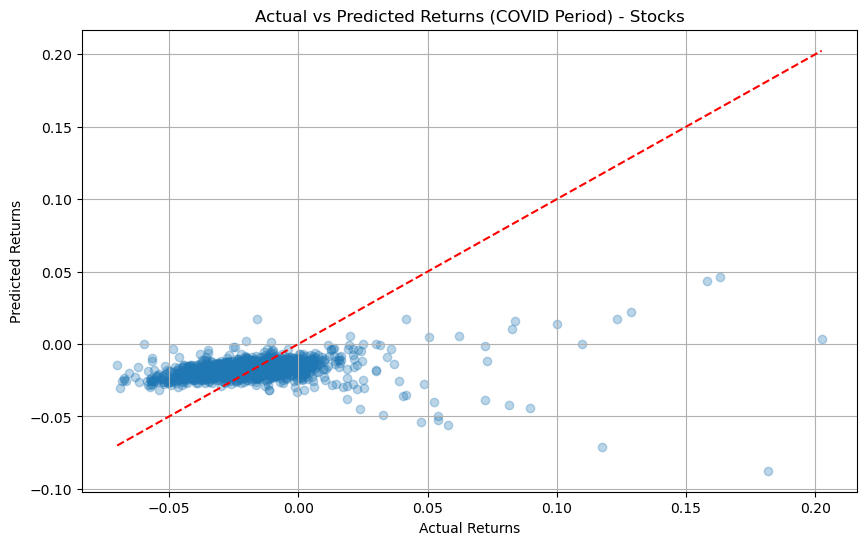

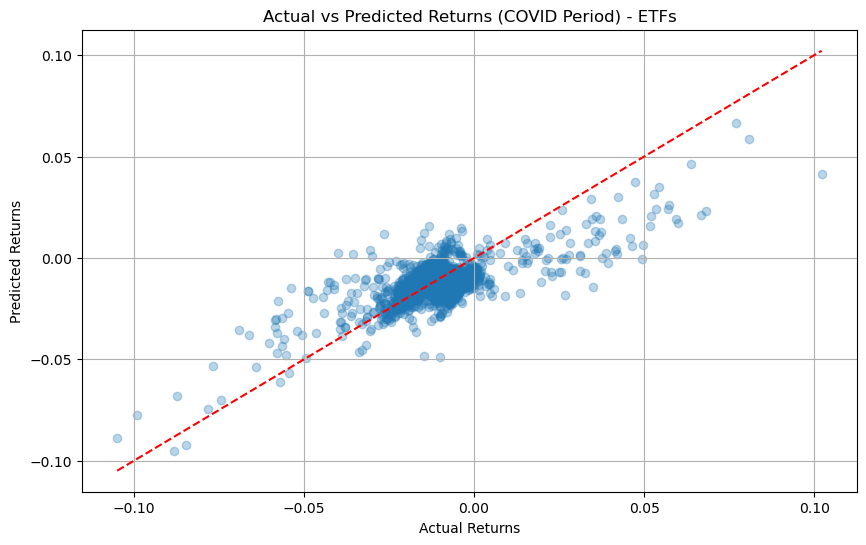

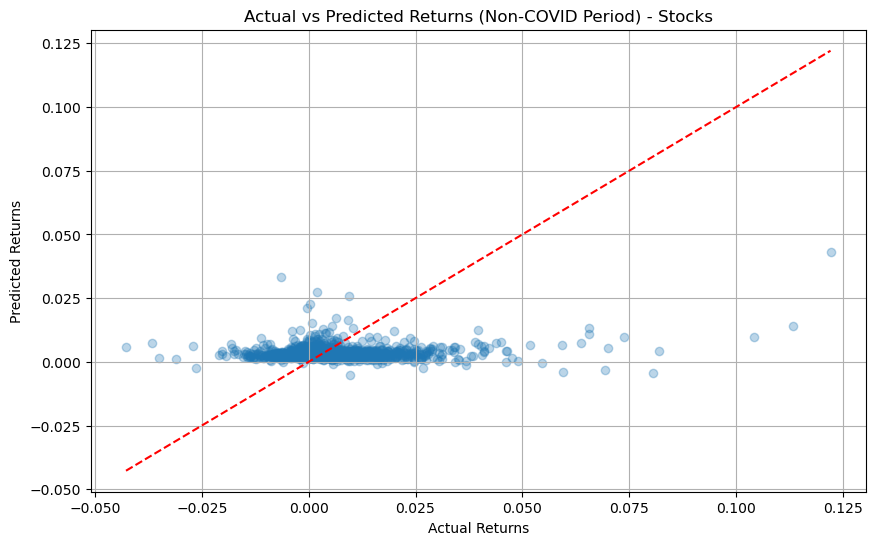

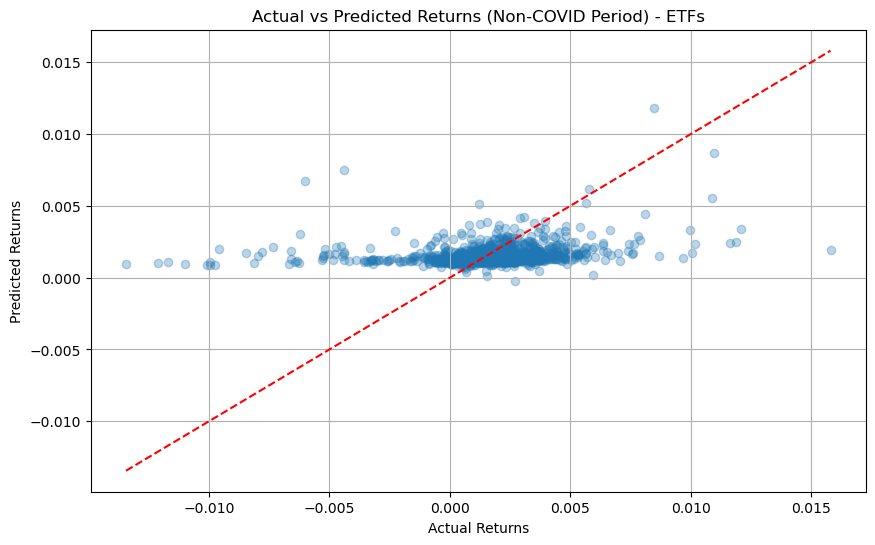

In [33]:
import matplotlib.pyplot as plt

# Function to create scatter plot of Actual vs Predicted Returns
def plot_actual_vs_predicted(model, X, y, title, filename):
    predictions = model.predict(X)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y, predictions, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 45-degree line
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title(title)
    plt.grid(True)
    
    # Save the plot
    plt.savefig(f"/Users/rohanpadaya/Desktop/pankit_assign/Task2_revised/{filename}")
    plt.show()

# Plot for each model
plot_actual_vs_predicted(model_stocks_covid, X_stocks_covid_clean, y_stocks_covid_clean, 
                         "Actual vs Predicted Returns (COVID Period) - Stocks", "stocks_covid_actual_vs_predicted.png")

plot_actual_vs_predicted(model_etfs_covid, X_etfs_covid_clean, y_etfs_covid_clean, 
                         "Actual vs Predicted Returns (COVID Period) - ETFs", "etfs_covid_actual_vs_predicted.png")

plot_actual_vs_predicted(model_stocks_non_covid, X_stocks_non_covid_clean, y_stocks_non_covid_clean, 
                         "Actual vs Predicted Returns (Non-COVID Period) - Stocks", "stocks_non_covid_actual_vs_predicted.png")

plot_actual_vs_predicted(model_etfs_non_covid, X_etfs_non_covid_clean, y_etfs_non_covid_clean, 
                         "Actual vs Predicted Returns (Non-COVID Period) - ETFs", "etfs_non_covid_actual_vs_predicted.png")

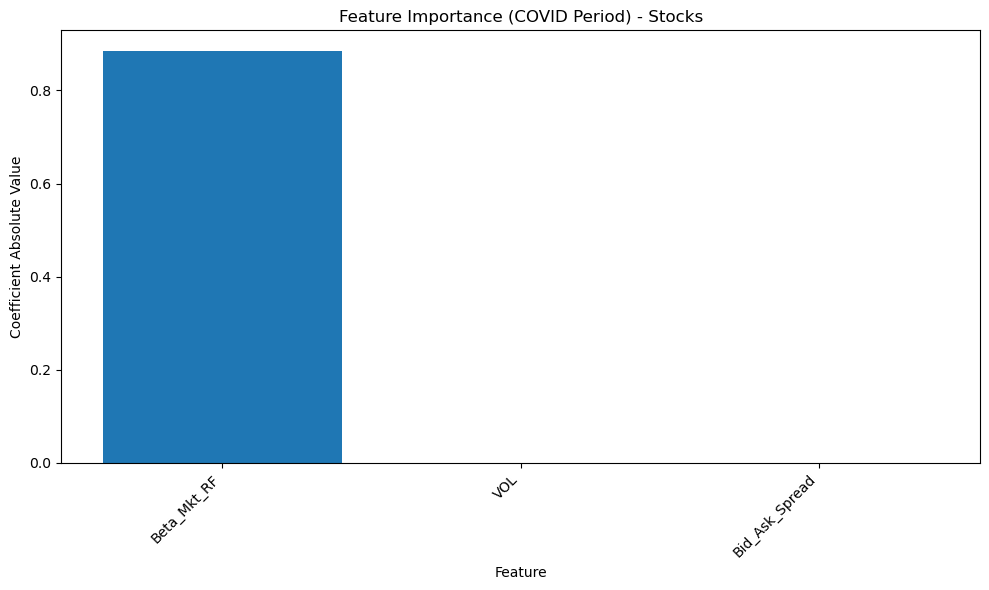

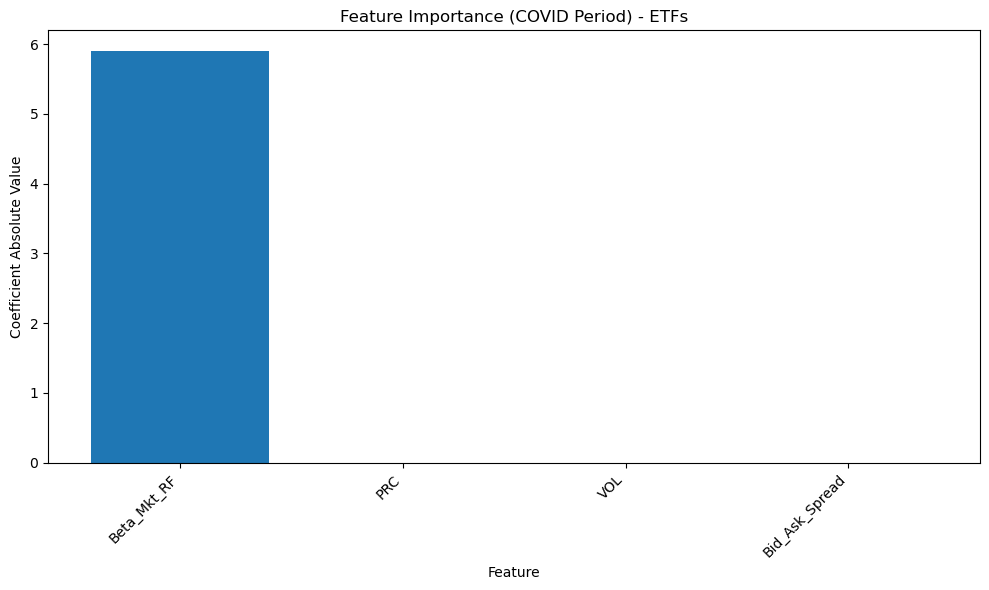

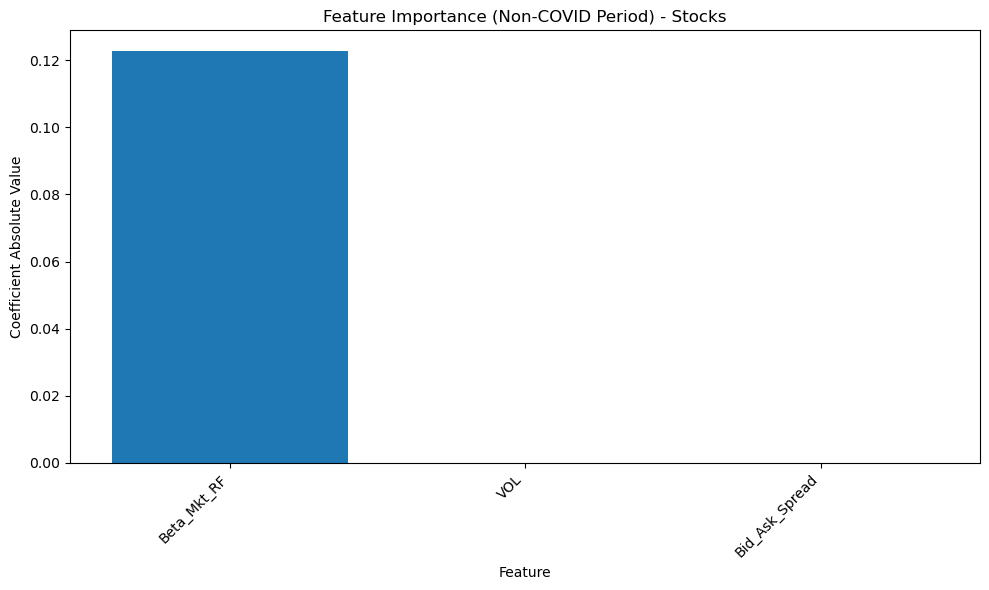

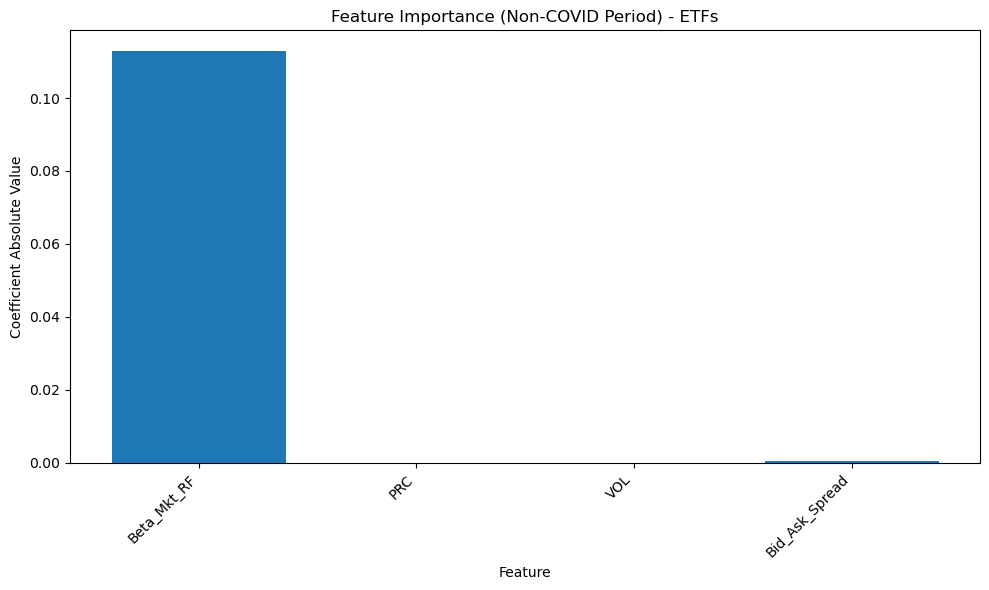

In [34]:
# Function to plot feature importance
def plot_feature_importance(model, title, filename):
    importance = model.params[1:]  # Skip the intercept
    features = importance.index
    coef_values = importance.values

    plt.figure(figsize=(10, 6))
    plt.bar(features, np.abs(coef_values))
    plt.xlabel('Feature')
    plt.ylabel('Coefficient Absolute Value')
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f"/Users/rohanpadaya/Desktop/pankit_assign/Task2_revised/{filename}")
    plt.show()

# Plot feature importance for each model
plot_feature_importance(model_stocks_covid, 
                        "Feature Importance (COVID Period) - Stocks", 
                        "stocks_covid_feature_importance.png")

plot_feature_importance(model_etfs_covid, 
                        "Feature Importance (COVID Period) - ETFs", 
                        "etfs_covid_feature_importance.png")

plot_feature_importance(model_stocks_non_covid, 
                        "Feature Importance (Non-COVID Period) - Stocks", 
                        "stocks_non_covid_feature_importance.png")

plot_feature_importance(model_etfs_non_covid, 
                        "Feature Importance (Non-COVID Period) - ETFs", 
                        "etfs_non_covid_feature_importance.png")

# Variance Inflation Factor (VIF) Calculation for Multicollinearity Assessment

In [25]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF
def calculate_vif(X):
    # Add a constant for VIF calculation
    X = sm.add_constant(X)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Drop the constant term before returning
    vif_data = vif_data.drop(index=0)
    return vif_data

# Calculate VIF for COVID Stocks
vif_stocks_covid = calculate_vif(X_stocks_covid_clean)

# Calculate VIF for COVID ETFs
vif_etfs_covid = calculate_vif(X_etfs_covid_clean)

# Calculate VIF for Non-COVID Stocks
vif_stocks_non_covid = calculate_vif(X_stocks_non_covid_clean)

# Calculate VIF for Non-COVID ETFs
vif_etfs_non_covid = calculate_vif(X_etfs_non_covid_clean)

# Display VIF values
print("VIF for COVID Stocks:")
print(vif_stocks_covid)

print("\nVIF for COVID ETFs:")
print(vif_etfs_covid)

print("\nVIF for Non-COVID Stocks:")
print(vif_stocks_non_covid)

print("\nVIF for Non-COVID ETFs:")
print(vif_etfs_non_covid)

VIF for COVID Stocks:
       Feature           VIF
1  Beta_Mkt_RF  3.336000e+13
2     Beta_SMB  2.061144e+13
3     Beta_HML  6.574598e+13
4          PRC  1.895360e+05
5          VOL  1.001097e+00
6        BIDLO  8.400754e+05
7        ASKHI  7.967338e+05

VIF for COVID ETFs:
       Feature           VIF
1  Beta_Mkt_RF  2.699191e+12
2     Beta_SMB  1.020068e+13
3     Beta_HML  4.330384e+13
4          PRC  4.823213e+01
5          VOL  1.024582e+00
6        BIDLO  2.591836e+02
7        ASKHI  2.730673e+02

VIF for Non-COVID Stocks:
       Feature           VIF
1  Beta_Mkt_RF  4.330384e+13
2     Beta_SMB  9.007199e+15
3     Beta_HML  3.602880e+14
4          PRC  2.417577e+05
5          VOL  1.006230e+00
6        BIDLO  3.713763e+06
7        ASKHI  3.647259e+06

VIF for Non-COVID ETFs:
       Feature           VIF
1  Beta_Mkt_RF  2.746097e+13
2     Beta_SMB  1.709146e+13
3     Beta_HML  5.773846e+13
4          PRC  2.957226e+01
5          VOL  1.023854e+00
6        BIDLO  1.449927e+04
7     

In [26]:
# Remove Beta_HML from the datasets
X_stocks_covid_reduced = X_stocks_covid_clean.drop(columns=['Beta_HML'])
X_etfs_covid_reduced = X_etfs_covid_clean.drop(columns=['Beta_HML'])
X_stocks_non_covid_reduced = X_stocks_non_covid_clean.drop(columns=['Beta_HML'])
X_etfs_non_covid_reduced = X_etfs_non_covid_clean.drop(columns=['Beta_HML'])

# Recalculate VIF for the reduced datasets
calculate_vif(X_stocks_covid_reduced)
calculate_vif(X_etfs_covid_reduced)
calculate_vif(X_stocks_non_covid_reduced)
calculate_vif(X_etfs_non_covid_reduced)

,Feature,VIF
1,Beta_Mkt_RF,8.417943e+12
2,Beta_SMB,4.666943e+13
3,PRC,2.957226e+01
4,VOL,1.023854e+00
5,BIDLO,1.449927e+04
6,ASKHI,1.464125e+04


In [27]:
# Create a bid-ask spread feature
X_stocks_covid_clean['Bid_Ask_Spread'] = X_stocks_covid_clean['ASKHI'] - X_stocks_covid_clean['BIDLO']
X_etfs_covid_clean['Bid_Ask_Spread'] = X_etfs_covid_clean['ASKHI'] - X_etfs_covid_clean['BIDLO']
X_stocks_non_covid_clean['Bid_Ask_Spread'] = X_stocks_non_covid_clean['ASKHI'] - X_stocks_non_covid_clean['BIDLO']
X_etfs_non_covid_clean['Bid_Ask_Spread'] = X_etfs_non_covid_clean['ASKHI'] - X_etfs_non_covid_clean['BIDLO']

# Drop the original BIDLO and ASKHI columns
X_stocks_covid_clean = X_stocks_covid_clean.drop(columns=['BIDLO', 'ASKHI'])
X_etfs_covid_clean = X_etfs_covid_clean.drop(columns=['BIDLO', 'ASKHI'])
X_stocks_non_covid_clean = X_stocks_non_covid_clean.drop(columns=['BIDLO', 'ASKHI'])
X_etfs_non_covid_clean = X_etfs_non_covid_clean.drop(columns=['BIDLO', 'ASKHI'])

In [28]:
# Drop the Beta_SMB feature
X_stocks_covid_clean = X_stocks_covid_clean.drop(columns=['Beta_SMB'])
X_etfs_covid_clean = X_etfs_covid_clean.drop(columns=['Beta_SMB'])
X_stocks_non_covid_clean = X_stocks_non_covid_clean.drop(columns=['Beta_SMB'])
X_etfs_non_covid_clean = X_etfs_non_covid_clean.drop(columns=['Beta_SMB'])

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(data):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = data.columns
    vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    return vif_data

# Recompute VIF for each dataset
print("VIF for COVID Stocks after adjustments:")
print(compute_vif(X_stocks_covid_clean))

print("\nVIF for COVID ETFs after adjustments:")
print(compute_vif(X_etfs_covid_clean))

print("\nVIF for Non-COVID Stocks after adjustments:")
print(compute_vif(X_stocks_non_covid_clean))

print("\nVIF for Non-COVID ETFs after adjustments:")
print(compute_vif(X_etfs_non_covid_clean))

VIF for COVID Stocks after adjustments:
          Feature           VIF
0           const  1.423654e+00
1     Beta_Mkt_RF  1.924615e+13
2        Beta_HML  1.217189e+14
3             PRC  9.600341e+02
4             VOL  1.000254e+00
5  Bid_Ask_Spread  9.600422e+02

VIF for COVID ETFs after adjustments:
          Feature           VIF
0           const  3.033388e+00
1     Beta_Mkt_RF  4.872444e+11
2        Beta_HML  2.649176e+14
3             PRC  1.651030e+00
4             VOL  1.024462e+00
5  Bid_Ask_Spread  1.651440e+00

VIF for Non-COVID Stocks after adjustments:
          Feature           VIF
0           const  1.302956e+00
1     Beta_Mkt_RF  6.004800e+14
2        Beta_HML  6.928615e+14
3             PRC  1.963491e+02
4             VOL  1.005052e+00
5  Bid_Ask_Spread  1.963479e+02

VIF for Non-COVID ETFs after adjustments:
          Feature           VIF
0           const  2.232914e+00
1     Beta_Mkt_RF  7.439048e+11
2        Beta_HML  1.197766e+13
3             PRC  1.834229e+00
4

In [30]:
from sklearn.preprocessing import StandardScaler

# Step 1: Drop Beta_HML from the datasets
X_stocks_covid_clean = X_stocks_covid_clean.drop(columns=['Beta_HML'])
X_etfs_covid_clean = X_etfs_covid_clean.drop(columns=['Beta_HML'])
X_stocks_non_covid_clean = X_stocks_non_covid_clean.drop(columns=['Beta_HML'])
X_etfs_non_covid_clean = X_etfs_non_covid_clean.drop(columns=['Beta_HML'])

# Step 2: Standardize PRC and Bid_Ask_Spread
scaler = StandardScaler()
X_stocks_covid_clean[['PRC', 'Bid_Ask_Spread']] = scaler.fit_transform(X_stocks_covid_clean[['PRC', 'Bid_Ask_Spread']])
X_etfs_covid_clean[['PRC', 'Bid_Ask_Spread']] = scaler.fit_transform(X_etfs_covid_clean[['PRC', 'Bid_Ask_Spread']])
X_stocks_non_covid_clean[['PRC', 'Bid_Ask_Spread']] = scaler.fit_transform(X_stocks_non_covid_clean[['PRC', 'Bid_Ask_Spread']])
X_etfs_non_covid_clean[['PRC', 'Bid_Ask_Spread']] = scaler.fit_transform(X_etfs_non_covid_clean[['PRC', 'Bid_Ask_Spread']])

# Step 3: Recompute VIF
print("VIF for COVID Stocks after adjustments:")
print(compute_vif(X_stocks_covid_clean))

print("\nVIF for COVID ETFs after adjustments:")
print(compute_vif(X_etfs_covid_clean))

print("\nVIF for Non-COVID Stocks after adjustments:")
print(compute_vif(X_stocks_non_covid_clean))

print("\nVIF for Non-COVID ETFs after adjustments:")
print(compute_vif(X_etfs_non_covid_clean))

# Step 4: Refit the OLS models
model_stocks_covid = sm.OLS(y_stocks_covid_clean, X_stocks_covid_clean).fit()
model_etfs_covid = sm.OLS(y_etfs_covid_clean, X_etfs_covid_clean).fit()
model_stocks_non_covid = sm.OLS(y_stocks_non_covid_clean, X_stocks_non_covid_clean).fit()
model_etfs_non_covid = sm.OLS(y_etfs_non_covid_clean, X_etfs_non_covid_clean).fit()

# Evaluate the model again to see the improvements
evaluate_model_performance(model_stocks_covid, X_stocks_covid_clean, y_stocks_covid_clean)
evaluate_model_performance(model_etfs_covid, X_etfs_covid_clean, y_etfs_covid_clean)
evaluate_model_performance(model_stocks_non_covid, X_stocks_non_covid_clean, y_stocks_non_covid_clean)
evaluate_model_performance(model_etfs_non_covid, X_etfs_non_covid_clean, y_etfs_non_covid_clean)

VIF for COVID Stocks after adjustments:
          Feature         VIF
0           const    1.264197
1     Beta_Mkt_RF    1.000169
2             PRC  960.034086
3             VOL    1.000254
4  Bid_Ask_Spread  960.042174

VIF for COVID ETFs after adjustments:
          Feature       VIF
0           const  1.604043
1     Beta_Mkt_RF  1.024511
2             PRC  1.651030
3             VOL  1.024462
4  Bid_Ask_Spread  1.651440

VIF for Non-COVID Stocks after adjustments:
          Feature         VIF
0           const    1.108761
1     Beta_Mkt_RF    1.005149
2             PRC  196.349130
3             VOL    1.005052
4  Bid_Ask_Spread  196.347853

VIF for Non-COVID ETFs after adjustments:
          Feature       VIF
0           const  1.036780
1     Beta_Mkt_RF  1.018469
2             PRC  1.834229
3             VOL  1.023349
4  Bid_Ask_Spread  1.827330


(3.5077506963435997e-06,
 0.0018728990085809753,
 0.0011354867044473071,
 0.08207030903589874)

In [31]:
# Step 1: Drop PRC from the stocks datasets
X_stocks_covid_clean = X_stocks_covid_clean.drop(columns=['PRC'])
X_stocks_non_covid_clean = X_stocks_non_covid_clean.drop(columns=['PRC'])

# Recompute VIF
print("VIF for COVID Stocks after dropping PRC:")
print(compute_vif(X_stocks_covid_clean))

print("\nVIF for Non-COVID Stocks after dropping PRC:")
print(compute_vif(X_stocks_non_covid_clean))

# Step 2: Refit the OLS models for stocks
model_stocks_covid = sm.OLS(y_stocks_covid_clean, X_stocks_covid_clean).fit()
model_stocks_non_covid = sm.OLS(y_stocks_non_covid_clean, X_stocks_non_covid_clean).fit()

# Evaluate the model again to see the improvements
mse_stocks_covid, rmse_stocks_covid, mae_stocks_covid, r2_stocks_covid = evaluate_model_performance(model_stocks_covid, X_stocks_covid_clean, y_stocks_covid_clean)
mse_stocks_non_covid, rmse_stocks_non_covid, mae_stocks_non_covid, r2_stocks_non_covid = evaluate_model_performance(model_stocks_non_covid, X_stocks_non_covid_clean, y_stocks_non_covid_clean)

# Print the evaluation metrics
print("COVID Stocks Model Performance After Adjustments:")
print(f"MSE: {mse_stocks_covid}, RMSE: {rmse_stocks_covid}, MAE: {mae_stocks_covid}, R²: {r2_stocks_covid}")

print("\nNon-COVID Stocks Model Performance After Adjustments:")
print(f"MSE: {mse_stocks_non_covid}, RMSE: {rmse_stocks_non_covid}, MAE: {mae_stocks_non_covid}, R²: {r2_stocks_non_covid}")

VIF for COVID Stocks after dropping PRC:
          Feature       VIF
0           const  1.264196
1     Beta_Mkt_RF  1.000139
2             VOL  1.000169
3  Bid_Ask_Spread  1.000149

VIF for Non-COVID Stocks after dropping PRC:
          Feature       VIF
0           const  1.108754
1     Beta_Mkt_RF  1.004972
2             VOL  1.004983
3  Bid_Ask_Spread  1.000013
COVID Stocks Model Performance After Adjustments:
MSE: 0.00022688189028972281, RMSE: 0.015062599054934803, MAE: 0.00882358141032204, R²: 0.09235480886017078

Non-COVID Stocks Model Performance After Adjustments:
MSE: 7.110877945978082e-05, RMSE: 0.008432602176065276, MAE: 0.0047958233789897236, R²: 0.03946106586665743
